In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import bdms

In [2]:
df = pd.read_excel("240329Burst_summary_combined.xlsx", index_col=0).iloc[:, :12]

df = df.loc[df["# total GC seq"] >= df["# in bursting node"] + df["# desc of bursting node"]]

df = df.astype({"# total GC seq": int, "# in bursting node": int, "# desc of bursting node": int})

df["# total in burst"] = df["# in bursting node"] + df["# desc of bursting node"]
df["population fraction estimate"] = df["BB density"] * df["# total in burst"] / df["# total GC seq"]
df["parental fraction"] = df["# in bursting node"] / df["# total in burst"]

df.drop(index=["G_GC2_1", "M7-6.1:12_1 G"])

df

,# in bursting node,# desc of bursting node,# total GC seq,BB density,Normalization factor,Norm burst,Norm desc,Unnamed: 8,# divisions,dpi,dpt,Unnamed: 12,# total in burst,population fraction estimate,parental fraction
ID,,,,,,,,,,,,,,,
RY_GC6_1,12,8,27,0.717,53.111111,637.333333,424.888889,60.000000,9.315904,17.0,10.0,NaN,20,0.531111,0.600000
C_GC3_2,31,42,78,0.748,19.179487,594.564103,805.538462,42.465753,9.215689,17.0,10.0,NaN,73,0.700051,0.424658
Y_GC4_2,6,26,62,0.652,21.032258,126.193548,546.838710,18.750000,6.979494,21.0,14.0,NaN,32,0.336516,0.187500
G_GC2_1,2,18,58,0.876,30.206897,60.413793,543.724138,10.000000,5.916806,21.0,14.0,NaN,20,0.302069,0.100000
C_GC5_3,15,15,44,0.656,29.818182,447.272727,447.272727,50.000000,8.805011,21.0,14.0,NaN,30,0.447273,0.500000
CR_GC5_1,5,7,28,0.763,54.500000,272.500000,381.500000,41.666667,8.090112,21.0,14.0,NaN,12,0.327000,0.416667
Tas_4_LN1_GC1,6,28,52,0.918,35.307692,211.846154,988.615385,17.647059,7.726873,15.0,10.0,NaN,34,0.600231,0.176471
Tas_4_LN2_GC1,17,45,70,0.955,27.285714,463.857143,1227.857143,27.419355,8.857537,15.0,10.0,NaN,62,0.845857,0.274194
Tas_S9_LN3_GC1,8,45,74,1.000,27.027027,216.216216,1216.216216,15.094340,7.756331,15.0,10.0,NaN,53,0.716216,0.150943


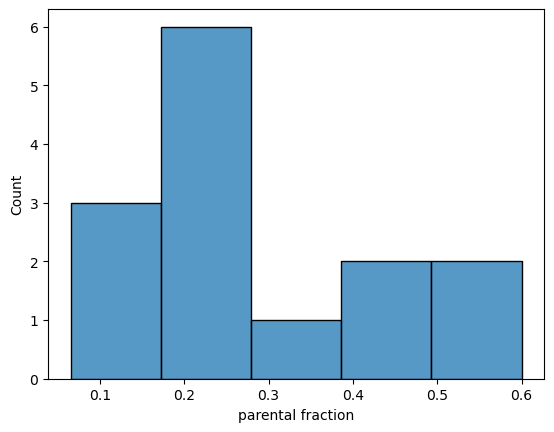

In [3]:
sns.histplot(data=df, x="parental fraction")
plt.show()

In [4]:
def null_sim(birth_mutation_prob, N, n, stop_freq, rng):
    birth_rate = 1.0
    stop_death_rate = 100. * birth_rate

    types = [0, 1, 2]

    P = np.array([
        [0, 1 - stop_freq, stop_freq],
        [0, 1 - stop_freq, stop_freq],
        [0, 0, 1]
    ])

    tree = bdms.Tree(state=0)

    tree.evolve(
        np.inf,
        birth_process=bdms.poisson.ConstantProcess(birth_rate),
        death_process=bdms.poisson.DiscreteProcess([0, 0, stop_death_rate]),
        mutation_process=bdms.poisson.ConstantProcess(0.0),
        mutator=bdms.mutators.DiscreteMutator(types, P),
        birth_mutation_prob=birth_mutation_prob,
        capacity=N,
        capacity_method="stop",
        seed=rng,
    )

    tree.sample_survivors(n=n, seed=rng)
    tree.prune_unsampled()

    return tree
    

In [5]:
birth_mutation_prob = 1 / 3
stop_freq = .01
N_total = 2000
n_sim = 1000
rng = np.random.default_rng(seed=0)

viz_kwargs = dict(
    color_map={0: "lightgrey", 1: "black", 2: "red"},
    units="in",
    h=2,
    mode="c",
    scale=10,
)

fig, axes = plt.subplots(2, 7, figsize=(12, 4), sharex=True, sharey=True)

for gc in df.index:
    print(gc)
    N = round(N_total * df.loc[gc, "population fraction estimate"])
    n = df.loc[gc, "# total in burst"]
    n_parental_true = df.loc[gc, "# in bursting node"]

    sim_df = pd.DataFrame(np.zeros((n_sim, 4)),
                          columns=["# parental", "# mutated", "# burst", "parental fraction"])

    for i in range(n_sim):
        tree = null_sim(birth_mutation_prob, N, n, stop_freq, rng)
        type_counts = Counter(leaf.state for leaf in tree)
        sim_df.loc[i, "# parental"] = type_counts[0]
        sim_df.loc[i, "# mutated"] = type_counts[1] + type_counts[2]
        sim_df.loc[i, "# burst"] = type_counts.total()
        sim_df.loc[i, "parental fraction"] = sim_df.loc[i, "# parental"] / sim_df.loc[i, "# burst"]

    # tree.render("%%inline", **viz_kwargs)

    p = (sim_df["parental fraction"] >= n_parental_true / n).mean()
    if p == 0:
        p = 1 / n_sim
        p_rel = "<"
    else:
        p_rel = "="

    plt.sca(axes.flat[df.index.get_loc(gc)])    
    sns.histplot(data=sim_df, x="parental fraction", bins=np.linspace(0, 1, 31))
    plt.axvline(n_parental_true / n, color="red")
    plt.annotate(f"{gc}\n{N=}\n{n=}\np{p_rel}{p:.1e}",
                 (0.99, 0.99), xycoords="axes fraction", ha="right", va="top",
                 fontsize=8)

plt.tight_layout()
plt.savefig("output/null_sim.pdf")
plt.show()

RY_GC6_1
C_GC3_2
Y_GC4_2
G_GC2_1
C_GC5_3
CR_GC5_1
Tas_4_LN1_GC1
Tas_4_LN2_GC1
Tas_S9_LN3_GC1
L1-3.1:15_12 R
M8-5.2:3_1 RY
M8-4.1:2_1 Y
M9-6.1:4_1 R
